# **Transformers Recommendation for Beckn Protocol**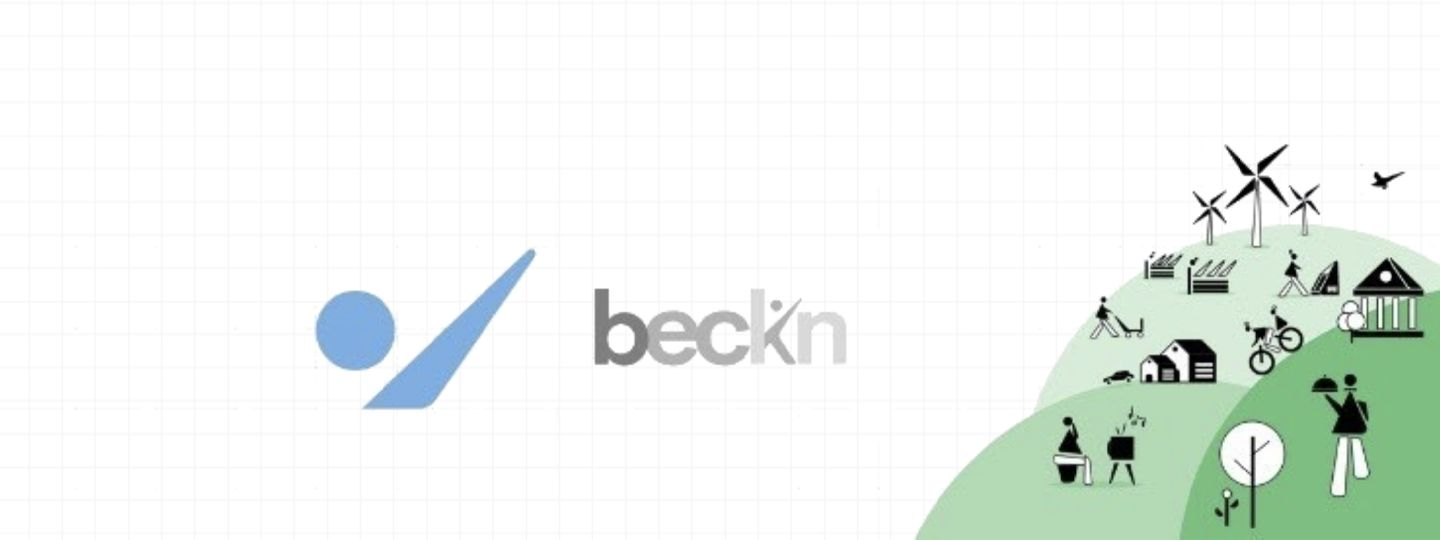

**Setup**

In [1]:
# Install annoy and transformers
!pip install -U annoy # Vectoriel Database

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=550737 sha256=62d116bb5c01e2c0bb1f1cc229ebdaca7f3ad2416d843a552aad75621f4b6ae2
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [2]:
!pip install -U sentence-transformers # NLP model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 98.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [3]:
import time
import numpy as np
from pandas import DataFrame
from annoy import AnnoyIndex
from tqdm import tqdm

import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [4]:
device = 'cuda' if torch.cuda.is_available else 'cpu' # Check the device
print(f'We are running on {device} device')

We are running on cuda device


In [5]:
# Let's print some observations
data = np.load('/content/drive/MyDrive/AI Clinic/LLM Recommendation/datas/prepare/beckn_place.npy', allow_pickle = True)
print(data[3:])

[["17 rue Lacepède, 75005 Paris https://hotel-saint-christophe.eu/fr/L'hôtel Saint-Christophe se situe à proximité de la station Place Monge (ligne 7), à dix minutes à pied du Panthéon. Ses chambres sont meublées avec sobriété et dotées d'un bureau et d'un minibar. Le petit déjeuner continental est servi dans une salle simple. La réception dispose d'une consigne à bagages. Les nombreux restaurants du quartier proposent une cuisine variée."
  'Hôtel Saint-Christophe' 3]
 ["46 avenue George V, 75008 Paris http://www.lefouquets-paris.com/L'hôtel Barrière Le Fouquet's Paris est installé dans immeuble Napoléon III du cœur de Paris. Ses chambres et suites - tons beiges et or, boiseries en acajou - sont haut de gamme. Elles sont dotées d'un dressing et d'une salle de bains en marbre. L'hôtel possède trois bars raffinés et un jardin privé. Ils proposent la dégustation de cocktails et de champagnes d'exceptions. Sa célèbre brasserie s'ouvre sur les Champs-Élysées. L'établissement abrite un spa,

In [6]:
print('The dim of the data = {}'.format(data.shape))

The dim of the data = (6040, 3)


## Embedding

In [7]:
data[:,1]

array(['Citadines Les Halles Paris', 'Adagio access Paris Reuilly',
       'Hôtel Excelsior Opéra', ..., 'Centre aquatique intercommunal',
       'Hôtel - Ibis Budget Paris Porte de Montmartre',
       "Restaurant l'inattendu"], dtype=object)

In [8]:
desc = data[:,0] # for desccription, we store all description in this variable to tokenize

In [9]:
model_bert = SentenceTransformer('distiluse-base-multilingual-cased')
model_bert.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.39k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [10]:
def generate_embeddings(text, model = model_bert):
  # Generate Embedding by using a pretrained model
  embeddings = model_bert.encode(text, convert_to_tensor=True)
  return embeddings

In [11]:
start = time.time()
sentence_emb = [generate_embeddings(text) for text in tqdm(desc)]
end = time.time()
print('Embedding takes {:.2f} min'.format((end-start)/60))

100%|██████████| 6040/6040 [00:49<00:00, 121.56it/s]

Embedding takes 0.83 min


## Annoy

In [12]:
emb_dim = 512 # 512 is the output of embedding of bert
print(f'The size of the embedding is {emb_dim}')
annoyindex = AnnoyIndex(emb_dim, 'angular')
print('The Annoy VectorBase initialized !')

for i,emb in enumerate(sentence_emb):
  emb_cpu = emb.squeeze().cpu().numpy()
  annoyindex.add_item(i, emb_cpu)

annoyindex.build(10)

The size of the embedding is 512
The Annoy VectorBase initialized !


True

In [13]:
def recommendation_system(input, num_recommendation = 5):
  # Recommend system function
  pd_data = DataFrame(data)
  input_emb = generate_embeddings(input)
  input_cpu = input_emb.squeeze().cpu().numpy()
  NN = annoyindex.get_nns_by_vector(input_cpu, num_recommendation)
  recommend_places = [pd_data.iloc[idx][1] for idx in NN]

  return recommend_places

**Evaluation**

In [14]:
data_test = np.load('/content/drive/MyDrive/AI Clinic/LLM Recommendation/datas/prepare/test_data.npy', allow_pickle = True)

In [15]:
# Initialize list to store result
true_labels = []
predicted_labels = []

# Navigate in the file
start = time.time()
for input_text, true_label in tqdm(zip(data_test[:,0], data_test[:,1])):
    recommendations = recommendation_system(input_text)
    true_labels.append(true_label)

    if any(label in recommendations for label in true_label):
        predicted_labels.append(true_label)
    else:
        predicted_labels.append(recommendations[0])

end = time.time()
print('Time elapsed : {:.3f}min'.format((end-start)/60))

# Metrics
precision = precision_score(true_labels, predicted_labels, average = 'micro')
recall = recall_score(true_labels, predicted_labels, average = 'micro')
accuracy = accuracy_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

6041it [00:54, 111.10it/s]


Time elapsed : 0.906min
Precision: 0.9963582188379407
Recall: 0.9963582188379407
Accuracy: 0.9963582188379407


## Inference

In [16]:
prompt = 'Recommende moi un hotel a Colombes'

recommendations = recommendation_system(prompt)
print("Recommended places similar to the input description:")
for idx, place in enumerate(recommendations, start=1):
    print(f"{idx}. {place}")

Recommended places similar to the input description:
1. Adagio access Colombes
2. B&B Hôtel CORBEIL-ESSONNES
3. Kyriad Paris Ouest Colombes
4. Aigle Noir Hôtel Fontainebleau – MGallery
5. Séjours et affaires atlantis


In [18]:
sentence_emb_cpu = [emb.cpu().numpy() for emb in sentence_emb]
np.save('embedding_data.npy', sentence_emb_cpu)
annoyindex.save('annoy_index.ann')
print('Annoy index and embeddings saved successfully!')

Annoy index and embeddings saved successfully!
